In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import yaml



2023-12-12 16:04:43.631500: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 16:04:43.671927: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 16:04:43.672927: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 16:04:44.300435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
np.random.seed(42)

# Set the path to the dataset
dataset_path = '.'

# Set the paths to images and annotations
images_folder = os.path.join(dataset_path, 'Images')
annotations_folder = os.path.join(dataset_path, 'Bounding_Boxes')

# Model configuration
input_shape = (512, 512, 3)  # Adjust based on your image size

In [3]:
class BoundingBox:
    def __init__(self, xmin, ymin, xmax, ymax, class_id, img_path):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.class_id = class_id
        self.img_path = img_path

    def __repr__(self):
        return f'[{self.xmin}, {self.ymin}, {self.xmax}, {self.ymax} | {self.class_id}]'


In [4]:
# Data preprocessing and loading
def load_data():
    images = []
    annotations = []
    label_map = {}

    # Open Bounding_Boxes/darknet.labels and read class names and put into label_map
    with open(os.path.join(annotations_folder, 'darknet.labels'), 'r') as f:
        class_names = f.readlines()
        for i, class_name in enumerate(class_names):
            label_map[i] = class_name.strip()

    # return images, labels
    for annotation_name in os.listdir(annotations_folder):

        # If no .txt files, continue
        if not annotation_name.endswith('.txt'):
            continue

        # Load image
        image_name = annotation_name.replace('.txt', '.jpg')
        image_path = os.path.join(images_folder, image_name)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_image_width, original_image_height = image.shape[1], image.shape[0]
        image = cv2.resize(image, (input_shape[0], input_shape[1]))

        images.append(image)

        # Load annotations
        annotation_path = os.path.join(annotations_folder, annotation_name)
        with open(annotation_path, 'r') as f:
            # Parse bounding box coordinates and class label
            # Example format: class x_min y_min x_max y_max
            lines = f.readlines()
            sub_annotations = []
            for line in lines:
                line = line.strip().split(' ')
                class_label, x_center_relativ, y_center_relativ, width_relativ, height_relativ = map(float, line)

                # Convert normalized coordinates to absolute coordinates
                x_min = int((x_center_relativ - width_relativ / 2) * original_image_width)
                y_min = int((y_center_relativ - height_relativ / 2) * original_image_height)
                x_max = int((x_center_relativ + width_relativ / 2) * original_image_width)
                y_max = int((y_center_relativ + height_relativ / 2) * original_image_height)

                # Rescale coordinates to input_shape
                x_min = int(x_min * input_shape[0] / original_image_width)
                y_min = int(y_min * input_shape[1] / original_image_height)
                x_max = int(x_max * input_shape[0] / original_image_width)
                y_max = int(y_max * input_shape[1] / original_image_height)

                # Store annotation information
                sub_annotations.append(BoundingBox(x_min, y_min, x_max, y_max, int(class_label), image_path))

            annotations.append(sub_annotations)

    # images = np.array(images)

    return images, annotations, label_map


# Load and preprocess the data
images, annotations, label_map = load_data()

images, len(annotations), label_map


([array([[[229, 165,  65],
          [233, 169,  67],
          [236, 173,  69],
          ...,
          [229, 176,  57],
          [228, 177,  64],
          [232, 185,  92]],
  
         [[236, 172,  72],
          [231, 168,  65],
          [233, 170,  65],
          ...,
          [232, 178,  59],
          [226, 175,  62],
          [236, 186,  94]],
  
         [[238, 175,  71],
          [231, 168,  63],
          [226, 162,  56],
          ...,
          [228, 172,  54],
          [222, 169,  57],
          [235, 185,  93]],
  
         ...,
  
         [[235, 171,  71],
          [233, 169,  69],
          [232, 169,  66],
          ...,
          [236, 179,  61],
          [226, 175,  62],
          [238, 189,  99]],
  
         [[233, 171,  70],
          [236, 174,  72],
          [238, 176,  73],
          ...,
          [227, 171,  64],
          [229, 175,  80],
          [239, 188, 107]],
  
         [[230, 168,  67],
          [235, 173,  70],
          [238, 176,  72

In [5]:
annotations[0]


[[25, 48, 439, 61 | 1],
 [25, 61, 438, 73 | 1],
 [25, 74, 437, 86 | 1],
 [25, 87, 437, 98 | 1],
 [25, 98, 437, 111 | 1],
 [25, 112, 439, 122 | 1],
 [23, 122, 438, 135 | 1],
 [23, 136, 439, 148 | 1],
 [25, 186, 437, 197 | 1],
 [25, 197, 438, 209 | 1],
 [22, 209, 437, 222 | 1],
 [26, 263, 437, 274 | 1],
 [25, 274, 437, 286 | 1],
 [25, 288, 437, 299 | 1],
 [25, 342, 438, 352 | 1],
 [23, 352, 440, 364 | 1],
 [25, 365, 437, 377 | 1],
 [26, 417, 437, 430 | 1],
 [25, 430, 438, 441 | 1],
 [25, 439, 437, 466 | 1],
 [26, 466, 437, 478 | 1],
 [110, 159, 283, 171 | 0],
 [97, 236, 286, 250 | 0],
 [108, 312, 280, 327 | 0],
 [90, 389, 298, 405 | 0],
 [69, 22, 308, 36 | 0],
 [22, 16, 441, 151 | 2],
 [18, 160, 441, 234 | 2],
 [19, 233, 443, 304 | 2],
 [18, 308, 443, 385 | 2],
 [18, 388, 443, 482 | 2]]

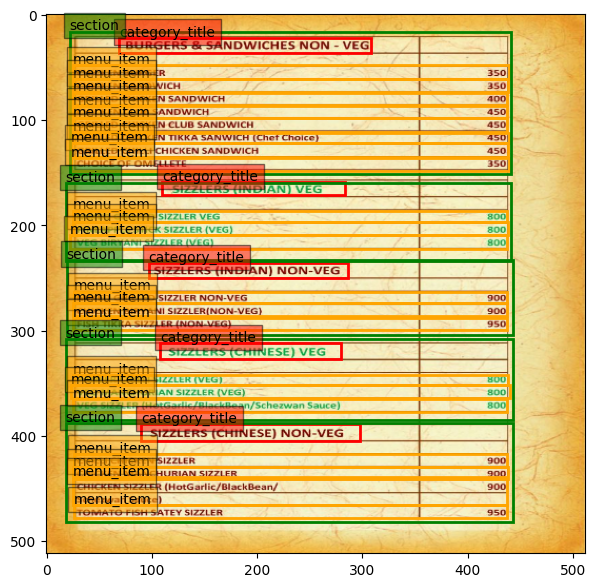

In [6]:
# Helper function to visualize bounding boxes
# It takes an image and a list of bounding boxes as inputs and plots an image with all the bounding boxes
# Each bounding box class should have a different color

color_map = {0: 'red', 1: 'orange', 2: 'green'}

def visualize_bounding_boxes(image, annotations):
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        xmin, ymin, xmax, ymax, class_id = annotation.xmin, annotation.ymin, annotation.xmax, annotation.ymax, annotation.class_id

        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color_map[class_id], linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, label_map[class_id], bbox=dict(facecolor=color_map[class_id], alpha=0.5))


plt.figure(figsize=(7, 7))

visualize_bounding_boxes(images[0], annotations[0])
plt.show()




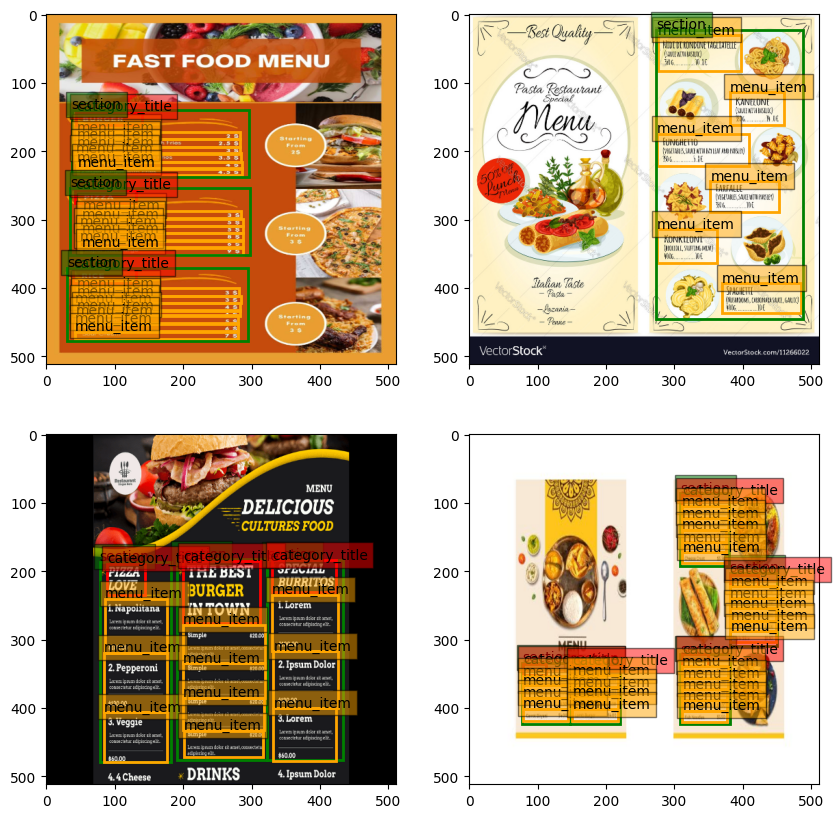

In [7]:
# Draw 4 randim images with bounding boxes in a 2x2 grid
plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    random_index = np.random.randint(len(images))
    visualize_bounding_boxes(images[random_index], annotations[random_index])
plt.show()

In [8]:
def create_dir_or_clean(path):
    os.makedirs(path, exist_ok=True)
    for file in os.listdir(path):
        os.remove(os.path.join(path, file))

def save_images_and_txt_files(images, annotations, image_path, label_path, file_base_name):
    for i, (train_image, train_annotation) in enumerate(zip(images, annotations)):
        image_name = f'{file_base_name}_{i}.jpg'
        label_name = f'{file_base_name}_{i}.txt'

        # Write the image to disk using cv2. Keep in mind that the images are in RGB and cv2 uses BGR by default
        cv2.imwrite(os.path.join(image_path, image_name), cv2.cvtColor(train_image, cv2.COLOR_RGB2BGR))

        with open(os.path.join(label_path, label_name), 'w') as f:
            for annotation in train_annotation:
                f.write(f"{annotation[0]} {annotation[1]} {annotation[2]} {annotation[3]} {annotation[4]}\n")


In [9]:

# THis function has the following responsibilities:
# 1. Convert the annotations into the YOLO format
# 2. Split the data into train and validation sets
# 3. Save the data final_datasdet/images/train, final_datasdet/images/val and final_datasdet/labels/train, final_datasdet/labels/val
# 4. Save the label_map into final_datasdet/labels/darknet.labels
# 5. save the yolo configuration yaml file
def save_for_yolo_training(images, annotations):
    # Convert annotations into YOLO format
    yolo_annotations = []
    for sub_annotations in annotations:
        yolo_annotations.append([])
        for annotation in sub_annotations:
            x_center = (annotation.xmin + annotation.xmax) / 2
            y_center = (annotation.ymin + annotation.ymax) / 2
            width = annotation.xmax - annotation.xmin
            height = annotation.ymax - annotation.ymin

            # Normalize coordinates
            x_center /= input_shape[0]
            y_center /= input_shape[1]
            width /= input_shape[0]
            height /= input_shape[1]

            yolo_annotations[-1].append([annotation.class_id, x_center, y_center, width, height])

    # Split into train and validation sets
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, yolo_annotations, test_size=0.2, shuffle=True, random_state=42)

    # Create the directories
    image_train_path = 'final_dataset/images/train'
    image_val_path = 'final_dataset/images/val'
    label_train_path = 'final_dataset/labels/train'
    label_val_path = 'final_dataset/labels/val'
    create_dir_or_clean(image_train_path)
    create_dir_or_clean(image_val_path)
    create_dir_or_clean(label_train_path)
    create_dir_or_clean(label_val_path)

    # Save the images and labels
    save_images_and_txt_files(train_images, train_annotations, image_train_path, label_train_path, 'train')
    save_images_and_txt_files(val_images, val_annotations, image_val_path, label_val_path, 'val')

    # Copy the darknet.labels file to label train and val paths
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_train_path}')
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_val_path}')

    # Create and save the yolo configuration file
    yolo_config = {
        'path': os.path.abspath('final_dataset'),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(label_map),
        'names': label_map,

    }
    yaml.dump(yolo_config, open('final_dataset/yolo_config.yaml', 'w'))


save_for_yolo_training(images, annotations)


In [10]:
class grid_search_result:
    def __init__(self, name, results, params, output_path):
        self.name = name
        self.results = results
        self.params = params
        self.output_path = output_path
        

    def __repr__(self):
        return f'name: {self.name}\nresults: {self.results}\nparams: {self.params}\noutput_path: {self.output_path}'

In [11]:
from ultralytics import YOLO
from sklearn.model_selection import ParameterGrid
import uuid
from IPython.display import clear_output
import pickle

def get_persisted_state_path(persist_filename):
    if persist_filename is not None:
        return f"./{persist_filename}.pkl"
    return None

def load_persisted_state(persist_path):
    if os.path.exists(persist_path):
        with open(persist_path, 'rb') as f:
            return pickle.load(f)
    return None

def run_grid_search(learning_rates=[], batch_sizes=[], epochs=[], netw_archs=[], confidences=[], nms_thresholds=[], persist_state_filename=None):
    persist_path = None
    persisted_state = None
    if persist_state_filename is not None:
        persist_path = get_persisted_state_path(persist_state_filename)
        persisted_state = load_persisted_state(persist_path)

    if persisted_state is not None:
        print(f"Restoring persisted state from {persist_path}")

    pm_grid_space = persisted_state['pm_grid_space'] if persisted_state is not None else {'learning_rate': learning_rates,
                    'batch_size': batch_sizes,
                    'epochs': epochs,
                    'network_architecture': netw_archs,
                    'confidence': confidences}

    pm_grid = ParameterGrid(pm_grid_space)

    resultsList = persisted_state['resultsDict'] if persisted_state is not None else []

    index = persisted_state['index'] if persisted_state is not None else 0

    for index in range(index, len(pm_grid)):
        print(f"Training model {index+1}/{len(pm_grid)}........")

        name = "train-" + str(uuid.uuid4())
        params = pm_grid[index]
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        num_epochs = params['epochs']
        netw_arch = params['network_architecture']
        confidence = params['confidence']
        #nms_thresh = params['NMS_threshold']

        print(f"Params:\nlearning_rate: {learning_rate}\nbatch_size: {batch_size}\nnum_epochs: {num_epochs}\nnetwork_architecture: {netw_arch}\nconfidence: {confidence}")

        model = YOLO(f"{netw_arch}.yaml").load(f"{netw_arch}.pt") # from local file

        results = model.train(data = "./final_dataset/yolo_config.yaml",lrf = learning_rate, epochs = num_epochs, batch = batch_size, name = name, conf = confidence)

        # TODO: Save the results of the best epoch in the results.results_dict
        resultsList.append(grid_search_result(name, results.results_dict, params, results.save_dir))

        index += 1

        if persist_path is not None:
            # Save pm_grid and index and resultsDict to file
            with open(persist_path, 'wb') as f:
                pickle.dump({'pm_grid_space': pm_grid_space, 'index': index, 'resultsDict': resultsList}, f)

        clear_output(wait=True)

    return resultsList



In [34]:
# hyperparameters to search through
learning_rates = [0.001,0.01,0.1,0.5]
batch_sizes = [16,32,64]
epochs = [3,6,9,12]
netw_archs = ["yolov8n","yolov8m","yolov8x"] #"yolov8m" maybe auch
confidences = [0.25,0.5,0.75,1]
nms_thresholds = [0.25,0.5,0,75,1]
# number of filters
# number of layers
# activationfucntions

resultsList = run_grid_search(learning_rates, batch_sizes, epochs, netw_archs, confidences, nms_thresholds, persist_state_filename='grid_search_state_1')
resultsList


Restoring persisted state from ./grid_search_state_1.pkl
Training model 2/576........
Params:
learning_rate: 0.001
batch_size: 16
num_epochs: 3
network_architecture: yolov8m
confidence: 0.25

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6       

  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576, 192, 2]                 
 16                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192,

train: Scanning /home/niklas/uni/semester7/dasc2/data-challenge-project/Menu_Card_Transformation/final_dataset/labels/train.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]
val: Scanning /home/niklas/uni/semester7/dasc2/data-challenge-project/Menu_Card_Transformation/final_dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train-fccaba7e-a48d-4b04-a429-9e6db92964c1/labels.jpg... 

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train-fccaba7e-a48d-4b04-a429-9e6db92964c1
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      8.45G      3.075      4.063      2.475        748        640:  75%|███████▌  | 3/4 [00:08<00:02,  2.94s/it]

In [12]:
# Load the persisted state
persisted_state = load_persisted_state(get_persisted_state_path('grid_search_state_1'))
print(persisted_state['resultsDict'])

[name: train-c7b44478-425e-4218-8f00-f4e0149e3d6f
results: {'metrics/precision(B)': 0.0, 'metrics/recall(B)': 0.0, 'metrics/mAP50(B)': 0.0, 'metrics/mAP50-95(B)': 0.0, 'fitness': 0.0}
params: {'network_architecture': 'yolov8n', 'learning_rate': 0.001, 'epochs': 3, 'confidence': 0.25, 'batch_size': 16}
output_path: /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train-c7b44478-425e-4218-8f00-f4e0149e3d6f]


In [13]:
def find_best_model(resultsDict, metric="metrics/mAP50(B)"):
    """
    Finds the best model in the resultsDict based on the metric
    :param resultsDict: list of grid_search_result objects
    :param metric: metric to compare the models with. Available metrics are: metrics/precision(B), metrics/recall(B), metrics/mAP50(B), metrics/mAP50-95(B), fitness
    """
    best_model_results = None
    best_metric = -1
    for result in resultsDict:
        if result.results[metric] > best_metric:
            best_model_results = result
            best_metric = result.results[metric]

    return best_model_results

best_model_results = find_best_model(persisted_state['resultsDict'])
best_model_results


name: train-c7b44478-425e-4218-8f00-f4e0149e3d6f
results: {'metrics/precision(B)': 0.0, 'metrics/recall(B)': 0.0, 'metrics/mAP50(B)': 0.0, 'metrics/mAP50-95(B)': 0.0, 'fitness': 0.0}
params: {'network_architecture': 'yolov8n', 'learning_rate': 0.001, 'epochs': 3, 'confidence': 0.25, 'batch_size': 16}
output_path: /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train-c7b44478-425e-4218-8f00-f4e0149e3d6f

In [14]:
print("Best hyperparameters:")
best_model_results.params

Best hyperparameters:


{'network_architecture': 'yolov8n',
 'learning_rate': 0.001,
 'epochs': 3,
 'confidence': 0.25,
 'batch_size': 16}